# Simulating a Lidar

We read our stl file using numpy-stl.

We select all triangles in the xy plane to get a 2D projection

We then place the robot with the lidar on the map using xy coordinates and yaw as the orientation. We transform the points of the map to the lidar coordinate system and then convert the carthesian coordinate system to a polar coordinate system. We use a simplified robot that consists of only a point 

We sweep a full circle around the Lidar in segments which size depends on the Lidar resolution and we retain the closest point to construct our lidar scann.

In [1]:
%matplotlib inline
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt

In [2]:
min_range = 2.0
max_range = 12000.0
resolution = 1 # in degrees

In [3]:
#simulated_environment = 'piste'
#simulated_environment = 'square'
simulated_environment = 'test'

In [4]:
if simulated_environment == 'test':
    data = np.zeros(3, dtype=mesh.Mesh.dtype)
    data['vectors'][0] = np.array([[100., 500., 0],
                                   [100., 100., 0],
                                   [  0.,   0., 0]])
    data['vectors'][1] = np.array([[ 900., 100., 0],
                                   [1000.,   0., 0],
                                   [   0.,   0., 0]])
    data['vectors'][2] = np.array([[1000., 500., 0],
                                   [1000., 200., 0],
                                   [ 100., 500., 0]])
    env = mesh.Mesh(data, remove_empty_areas=False)
    env.update_units()
else:
    env = mesh.Mesh.from_file('%s.stl' % simulated_environment)

## Adjust coordinate system

In [5]:
env.x = env.x - env.x.min()
env.y = env.y - env.y.min()

## Select bottom Face

In [6]:
subset = env.vectors[(env.normals[:, 0] == 0.0) & (env.normals[:, 1] == 0.0) & (env.normals[:, 2] < 0.0)]

## Set initial Pose

In [7]:
pose = [900, 50, np.pi]
pose = [500, 50, np.radians(-45)]
#pose = [500, 50, 0]
#pose = [850, 52, 3.0892327760299634]
#pose = [753, 77, 2.792526803190927]
#pose = [ 166.648113,  213.283612,  0.20943951]
#pose = [ 215.555493,  223.679196,  0.20943951]
#pose = [ 260.735529,  234.518542,  0.2268928 ]
#pose = [107.199835, 189.184783, 1.30899694]
pose = [107, 189, 1.30899694]

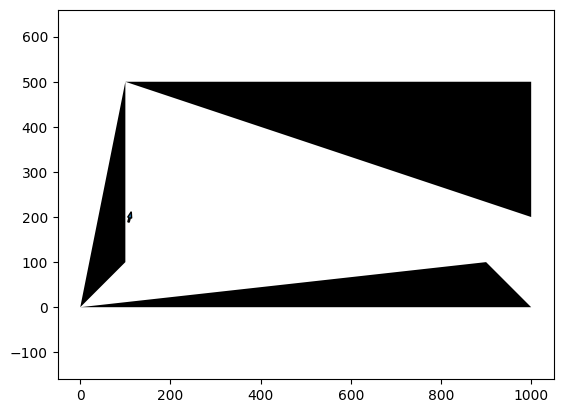

In [8]:
from matplotlib.patches import Polygon

fig,ax = plt.subplots()
for y in subset[:,:, 0:2]:
    p = Polygon(y, facecolor = 'k')
    ax.add_patch(p)
ax.axis('equal')
plt.arrow(pose[0], pose[1], 10 * np.cos(pose[2]), 10 * np.sin(pose[2]), width=3.0)

## Transform to Lidar Frame

In [9]:
env.x = env.x - pose[0]
env.y = env.y - pose[1]
env.rotate([0.0, 0.0, 1.0], pose[2])

In [10]:
subset = env.vectors[(env.normals[:, 0] == 0.0) & (env.normals[:, 1] == 0.0) & (env.normals[:, 2] < 0.0)]

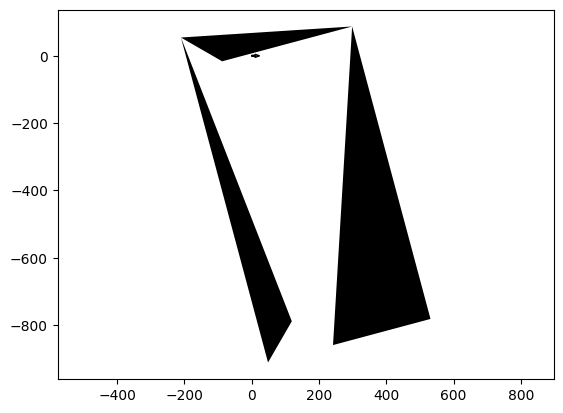

In [11]:
fig,ax = plt.subplots()
for y in subset[:,:, 0:2]:
    p = Polygon(y, facecolor = 'k')
    ax.add_patch(p)
ax.axis('equal')
plt.arrow(0, 0, 10, 0, width=3.0)

## Convert to polar coordinate system

In [12]:
import cmath
def cart2polC(xyz):
    x, y, z = xyz
    return(cmath.polar(complex(x, y))) # rho, phi
def convert_array(arr):
    theta = []
    r = []
    for x in arr:
        rho, phi = cart2polC(x)
        theta.append(phi)
        r.append(rho)
    return theta, r    

In [13]:
triangles = []
for t in subset[:,:, :]:
    a = np.array(convert_array(t)).transpose()
    triangles.append(a[a[:, 0].argsort()])
triangles = np.array(triangles) 

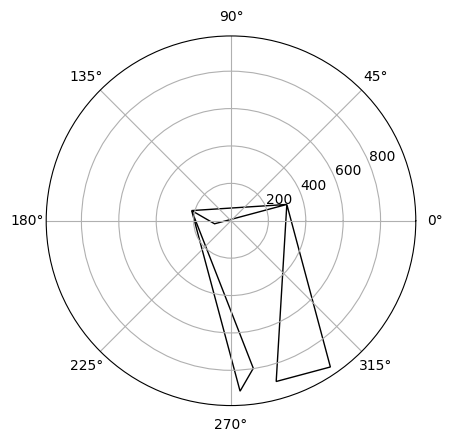

In [14]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for t in triangles:
    ax.fill(t[:, 0],t[:, 1],fill=False)

## Filter closest points


### Lines in poloar coordinates

A line in carthesian coordonate system is described as 
$$
y = m * x + b
$$
We make the following substitution:
$$
x = r * cos(\theta)
$$
$$
y = r * sin(\theta)
$$
Given two points in polar coordinates
$$
P_1 = (\theta_1, r_1)
$$
$$
P_2 = (\theta_2, r_2)
$$
we can calculate m and b. Finally we can calculate the intersection of the line connecting $P_1$ and $P_2$ with the line from the origin and an agle of $\theta$

In [15]:
import sympy as sp
from sympy.abc import theta

In [16]:
x,y = sp.symbols("x,y")
m,b,r,r1, r2 = sp.symbols("m,b,r,r1,r2", real=True)
theta_1, theta_2 = sp.symbols('theta_1,theta_2')

In [17]:
expr = y - m*x - b
expr = expr.subs(x, r * sp.cos(theta))
expr = expr.subs(y, r * sp.sin(theta))
expr

-b - m*r*cos(theta) + r*sin(theta)

In [18]:
p1 = expr.subs(r, r1).subs(theta, theta_1)
p2 = expr.subs(r, r2).subs(theta, theta_2)

In [19]:
p2.subs(b, 𝑟1 * sp.sin(theta_1)) - m * r1 * sp.cos(theta_1)

-m*r1*cos(theta_1) - m*r2*cos(theta_2) - r1*sin(theta_1) + r2*sin(theta_2)

In [40]:
def get_distance(p1, p2, theta):
    if not (p1[0] <= theta) & (theta <= p2[0]):
        return max_range + 1.0
    r_s_1 = np.sin(p1[0]) * p1[1]
    r_c_1 = np.cos(p1[0]) * p1[1]
    r_s_2 = np.sin(p2[0]) * p2[1]
    r_c_2 = np.cos(p2[0]) * p2[1]
    m = (r_s_2 - r_s_1) / (r_c_2 - r_c_1)
    b = r_s_1 - m * r_c_1
    dist = b / (np.sin(theta) - m * np.cos(theta))
    return dist

## Select Triangles hit by Ray

Must have vertices on both sides of the ray

Handle case where triangle is on both sides of the x axis

Handle case where triangle crosses +/- np.pi line

In [21]:
def filter_triangles(triangles, theta):
    special_cases = triangles[np.any(triangles >= 0, axis=1)[:,0] & np.any(triangles <0, axis=1)[:, 0]]
    other_cases = triangles[np.invert(np.any(triangles >= 0, axis=1)[:,0] & np.any(triangles <0, axis=1)[:, 0])]
    # verticies on both sides
    triangles_hit = other_cases[np.any(other_cases >= theta, axis=1)[:,0] & np.any(other_cases <= theta, axis=1)[:, 0]]
    # handle special cases:
    sc = []
    for t in special_cases:
        if ((t[:, 0].max() - t[:, 0].min()) < np.pi):
            # not so special after all
            if (theta <= t[:, 0].max()) & (t[:, 0].min() <= theta):
                sc.append(t)
        else:
            for e in t:
                if e[0] < 0:
                    e[0] += 2* np.pi
            if (theta + 2* np.pi <= t[:, 0].max()) & (t[:, 0].min() <= theta + 2* np.pi):
                sc.append(t)
            if (theta <= t[:, 0].max()) & (t[:, 0].min() <= theta):
                sc.append(t)

    #return triangles_hit
    return np.array(sc)

In [73]:
theta = np.radians(0) # OK
theta = np.radians(90) # NOT OK
theta = np.radians(-90) # NOT OK
theta = np.radians(180) # NOT OK

triangles_hit = filter_triangles(triangles, theta)
#print(theta)
#print(triangles)
#print(triangles_hit)

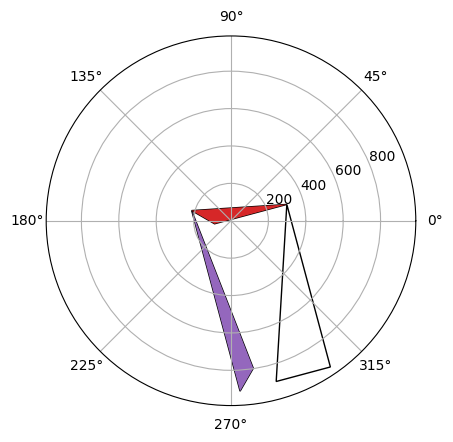

In [74]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for t in triangles:
    ax.fill(t[:, 0],t[:, 1],fill=False)
for t in triangles_hit:
    ax.fill(t[:, 0],t[:, 1],fill=True)

In [77]:
t = triangles[0]

In [78]:
intersection_points = np.empty((2, 2))
intersection_points[:, 0] = theta
points = []
dist = get_distance(t[0], t[1], theta)
if dist < max_range:
    points.append(dist)
dist = get_distance(t[0], t[2], theta)
if dist < max_range:
    points.append(dist)
dist = get_distance(t[1], t[2], theta)
if dist < max_range:
    points.append(dist)
intersection_points[0, 1] = points[0]
intersection_points[1, 1] = points[1]

IndexError: list index out of range

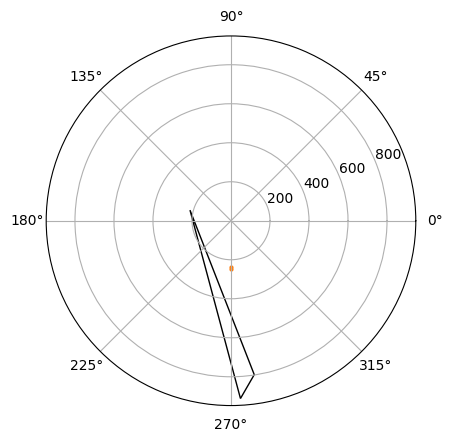

In [71]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.fill(t[:, 0],t[:, 1],fill=False)
ax.scatter(intersection_points[:, 0], intersection_points[:, 1], s=4.0)

In [ ]:
def lidar_filter(triangles):
    scann = []
    samples = np.arange(-np.pi, np.pi, np.radians(resolution))
    for sample in samples:
        #start with out of range
        dist = max_range + 1.0
        # select all triangles hit by the ray
        triangles_hit = triangles[np.any(triangles >= sample, axis=1)[:,0] & np.any(triangles <= sample, axis=1)[:, 0]]  
        for t in triangles_hit:       
            dist_t = np.empty(3)
            dist_t[0] = get_distance(t[0], t[1], sample)
            dist_t[1] = get_distance(t[0], t[2], sample)
            dist_t[2] = get_distance(t[1], t[2], sample)
            dist = min(dist_t.min(), dist) 
        scann.append(dist)
        if dist > max_range:
            scann[-1] = None
        if dist < min_range:
            scann[-1] = None
    return np.roll(np.array(scann), int(np.pi / np.radians(resolution)))       

In [ ]:
lidar_scann = lidar_filter(triangles)

In [ ]:
plot_scann = np.stack((np.arange(0, 2 * np.pi, np.radians(resolution)), lidar_scann), axis=1)
plot_scann = plot_scann[plot_scann[:, 1] != np.array(None)]

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(plot_scann[:, 0], plot_scann[:, 1], s=3.0)
for t in triangles:
    ax.fill(t[:, 0],t[:, 1],fill=False)
ax.set_rmax(1000)
ax.set_rticks([500, 1000])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Lidar Scann", va='bottom')